In [1]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Import Libraries**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.preprocessing import LabelEncoder

# **1. Exploratory Data Analysis (EDA)**
# **1.1 Loading Dataset**

In [3]:
path = "/content/drive/MyDrive/Techwiz/GlobalLandTemperaturesByCity.csv"
df = pd.read_csv(path)
df.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1743-11-01,6.068,1.737,Århus,Denmark,57.05N,10.33E
1,1743-12-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
2,1744-01-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
3,1744-02-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
4,1744-03-01,NaN,NaN,Århus,Denmark,57.05N,10.33E


In [4]:
print("Initial shape:", df.shape)

Initial shape: (8599212, 7)


# **1.2 Basic Dataset Info**

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8599212 entries, 0 to 8599211
Data columns (total 7 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   dt                             object 
 1   AverageTemperature             float64
 2   AverageTemperatureUncertainty  float64
 3   City                           object 
 4   Country                        object 
 5   Latitude                       object 
 6   Longitude                      object 
dtypes: float64(2), object(5)
memory usage: 459.2+ MB


In [6]:
print("Missing values per column:\n", df.isnull().sum())


Missing values per column:
 dt                                    0
AverageTemperature               364130
AverageTemperatureUncertainty    364130
City                                  0
Country                               0
Latitude                              0
Longitude                             0
dtype: int64


In [7]:
df.describe()

,AverageTemperature,AverageTemperatureUncertainty
count,8.235082e+06,8.235082e+06
mean,1.672743e+01,1.028575e+00
std,1.035344e+01,1.129733e+00
min,-4.270400e+01,3.400000e-02
25%,1.029900e+01,3.370000e-01
50%,1.883100e+01,5.910000e-01
75%,2.521000e+01,1.349000e+00
max,3.965100e+01,1.539600e+01


# **1.3 Missing Values Visualization**

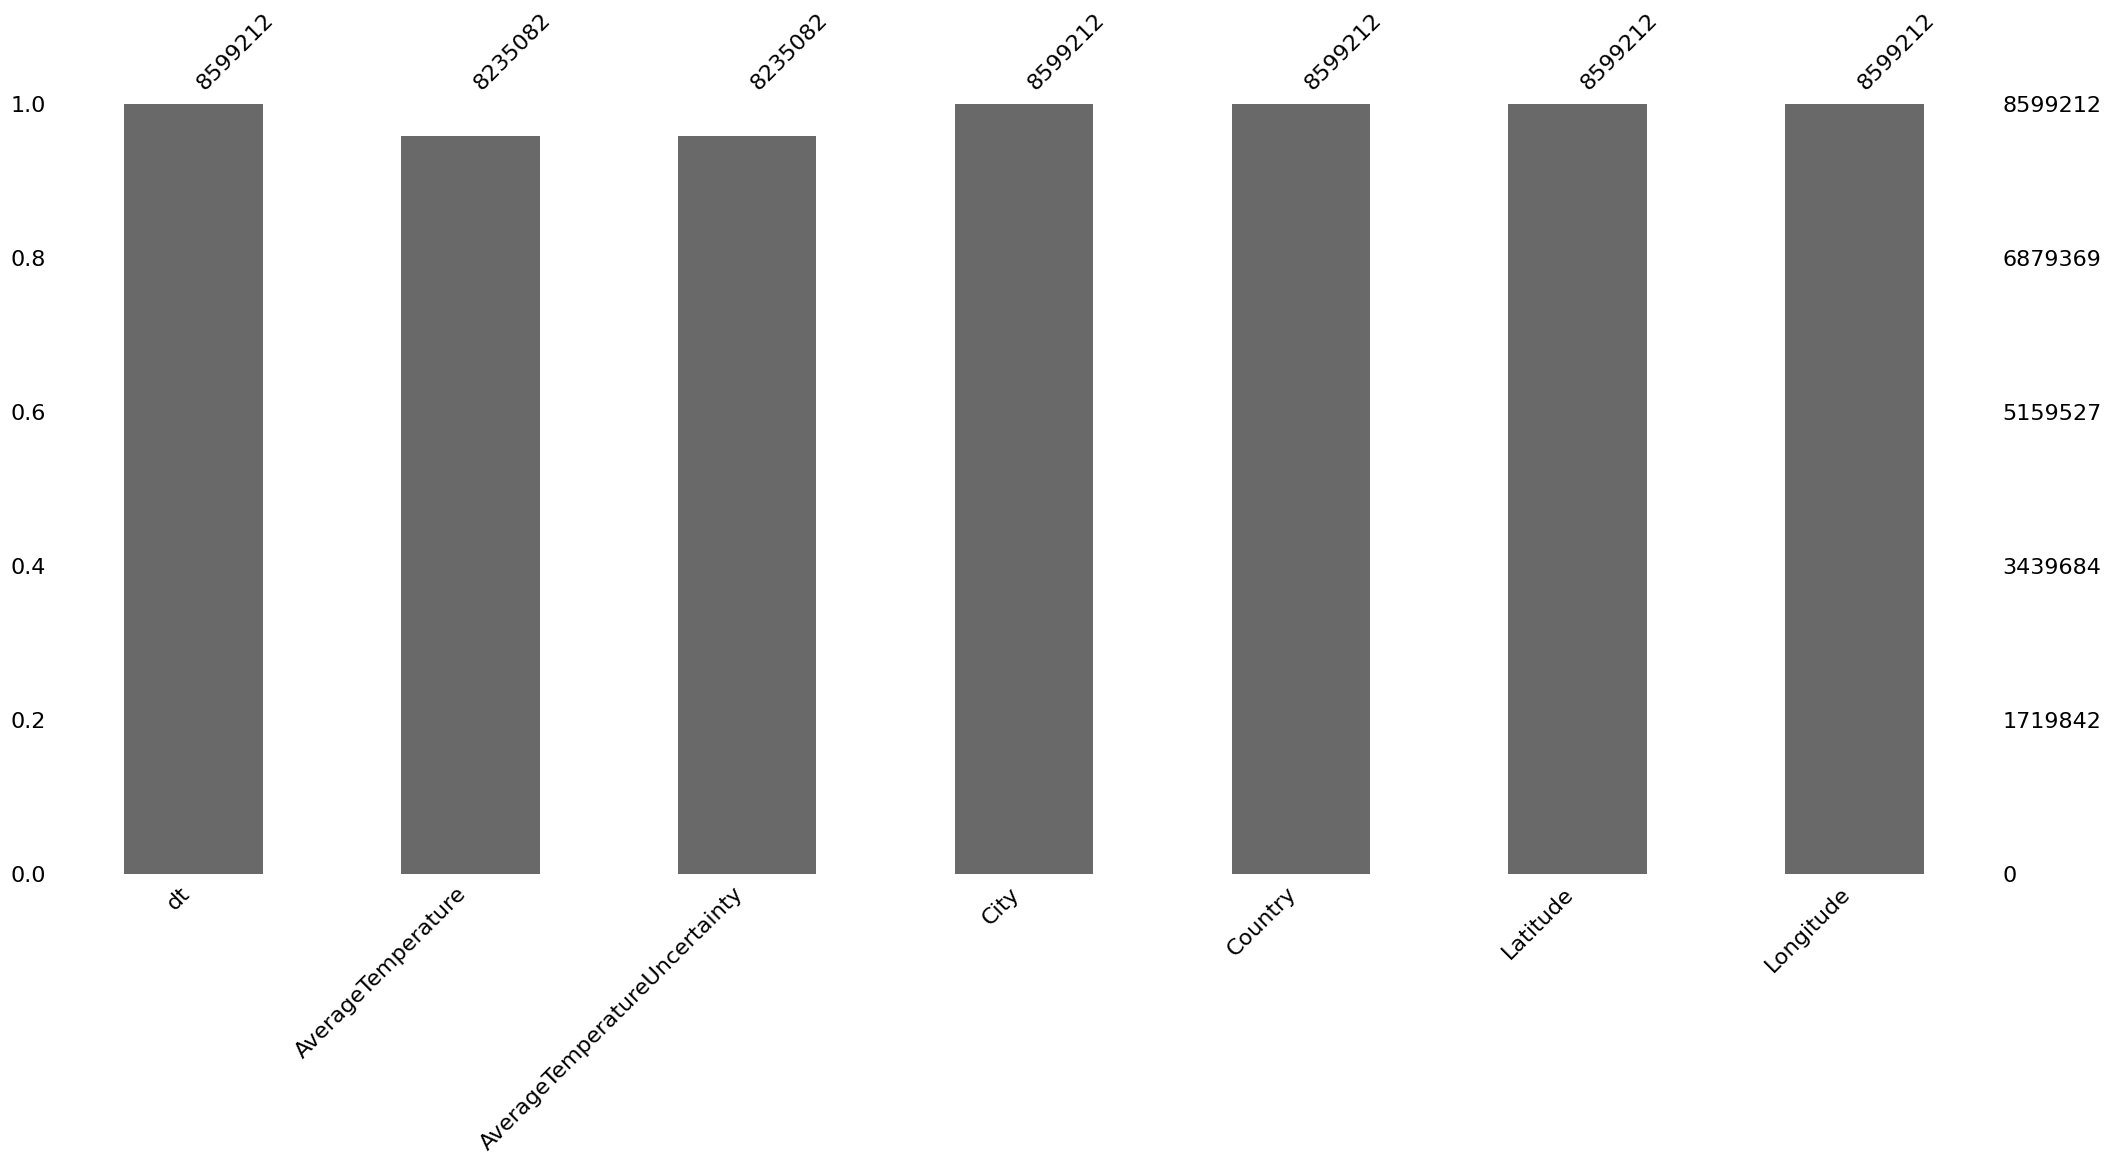

In [8]:
msno.bar(df)
plt.show()

# **1.4 Data Quality Checks**

In [9]:
print("Date range:", df['dt'].min(), "to", df['dt'].max())
print("Temperature range:", df['AverageTemperature'].min(), "to", df['AverageTemperature'].max())


Date range: 1743-11-01 to 2013-09-01
Temperature range: -42.70399999999999 to 39.651


# **1.5 Time Series Trend Analysis**

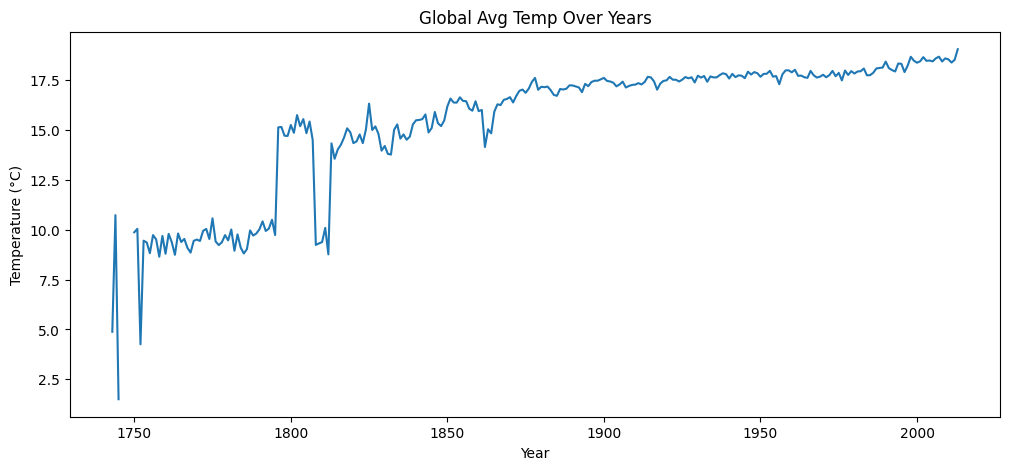

In [10]:
df['dt'] = pd.to_datetime(df['dt'], errors='coerce')
df['year'] = df['dt'].dt.year
df.groupby('year')['AverageTemperature'].mean().plot(figsize=(12,5), title="Global Avg Temp Over Years")
plt.xlabel("Year")
plt.ylabel("Temperature (°C)")
plt.show()


# **1.6 Seasonal Temperature Patterns**

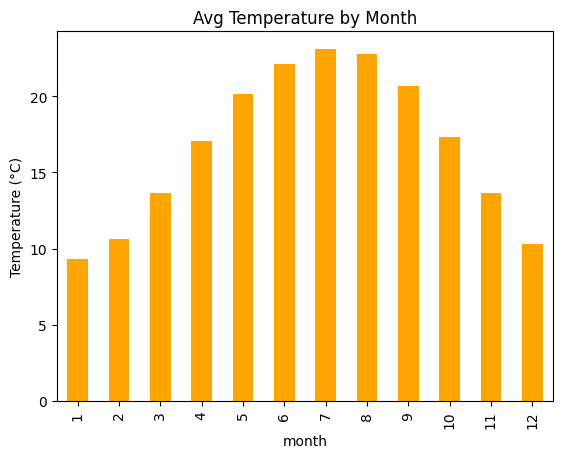

In [11]:
df['month'] = df['dt'].dt.month
df.groupby('month')['AverageTemperature'].mean().plot(kind='bar', title="Avg Temperature by Month", color='orange')
plt.ylabel("Temperature (°C)")
plt.show()

# **1.7 Geographic Temperature Patterns**

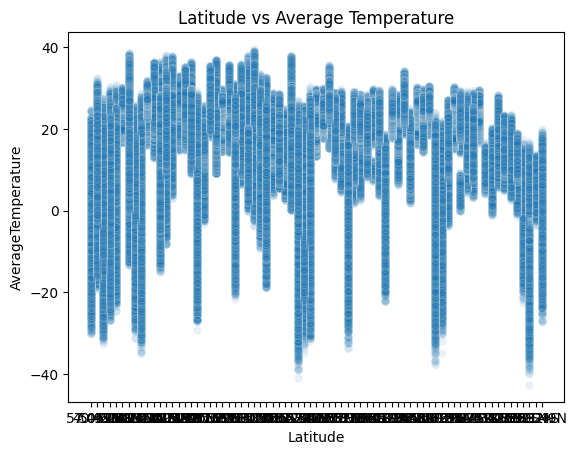

In [12]:
sns.scatterplot(x='Latitude', y='AverageTemperature', data=df, alpha=0.1)
plt.title("Latitude vs Average Temperature")
plt.show()

# **1.8 Country-Level Temperature Insights**

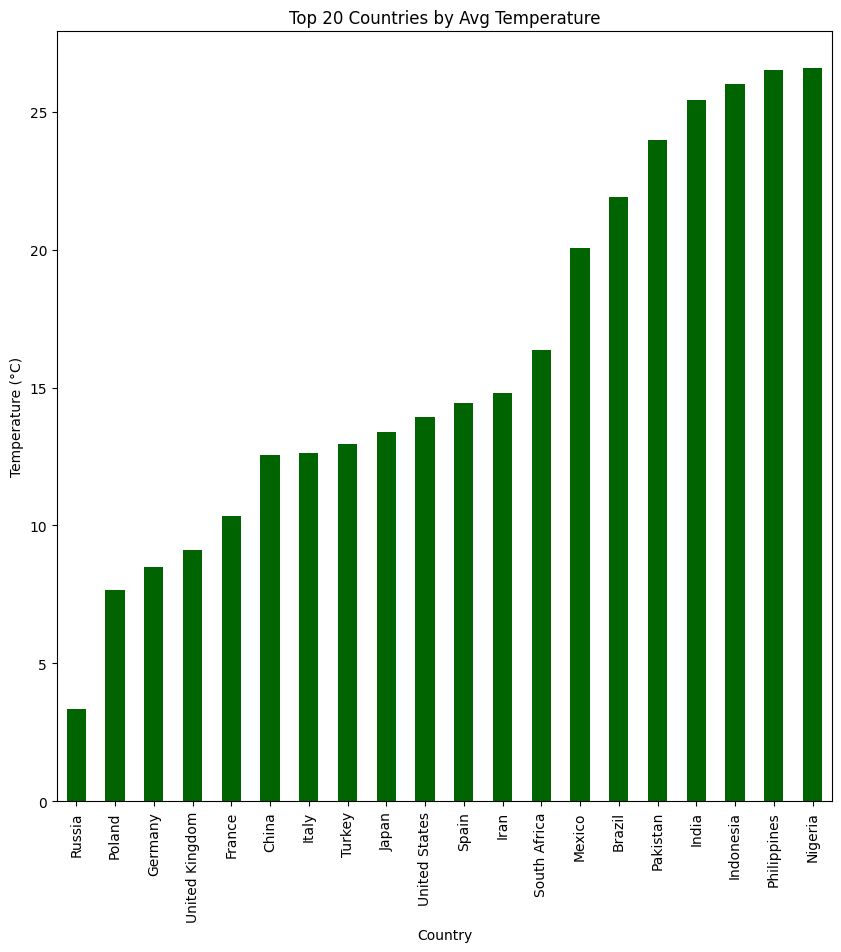

In [13]:
plt.figure(figsize=(10, 10))
top_countries = df['Country'].value_counts().head(20).index
df[df['Country'].isin(top_countries)].groupby('Country')['AverageTemperature'].mean().sort_values().plot(kind='bar', color='darkgreen')
plt.title("Top 20 Countries by Avg Temperature")
plt.ylabel("Temperature (°C)")
plt.show()

# **2. Data PREPROCESSING**

# **2.1 Remove Null Values**

In [14]:
df.isnull().sum()

,0
dt,0
AverageTemperature,364130
AverageTemperatureUncertainty,364130
City,0
Country,0
Latitude,0
Longitude,0
year,0
month,0


In [15]:
df.dropna(inplace = True)

In [16]:
print("After removing null targets:", df.shape)


After removing null targets: (8235082, 9)


# **2.2 Feature Engineering**

In [17]:
df['year'] = df['dt'].dt.year
df['month'] = df['dt'].dt.month
df['day'] = df['dt'].dt.day
# we extract seasons also, like (1:Winter, 2:Spring, 3:Summer, 4:Autumn)

df['season'] = df['month'] % 12 // 3 + 1

# **2.3 Convert Latitude & Longitude to Numeric**

In [18]:
df['Latitude'] = df['Latitude'].apply(lambda x: float(x[:-1]) * (-1 if x[-1] == 'S' else 1))
df['Longitude'] = df['Longitude'].apply(lambda x: float(x[:-1]) * (-1 if x[-1] == 'W' else 1))


# **2.4 Encode Categorical Variables**

In [19]:
le_country = LabelEncoder()
le_city = LabelEncoder()

df['Country'] = le_country.fit_transform(df['Country'])
df['City'] = le_city.fit_transform(df['City'])

# **2.5 Select Features & Target**

In [20]:
features = [
    'year', 'month', 'day', 'season',
    'Latitude', 'Longitude',
    'Country', 'City',
    'AverageTemperatureUncertainty'
]
target = 'AverageTemperature'

X = df[features]
y = df[target]

In [21]:
print("Final feature set shape:", X.shape)
print("Target shape:", y.shape)


Final feature set shape: (8235082, 9)
Target shape: (8235082,)


# **3. Model Development**

# **Model 1 — Linear Regression**
# **3.1 Imports the Required Libraries**

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import joblib


# **3.2 Train-Test Split**

In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)
print(f"Training set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")

Training set size: (5764557, 9)
Testing set size: (2470525, 9)


# **3.2 Model Initialization**

In [24]:
lr_model = LinearRegression()

# **3.3 Model Training**

In [25]:
lr_model.fit(X_train, y_train)
print("Linear Regression model trained successfully.")

Linear Regression model trained successfully.


# **3.4 Model Prediction**

In [26]:
lr_pred = lr_model.predict(X_test)

# **4. Model Evaluation**

In [27]:
lr_mae = mean_absolute_error(y_test, lr_pred)
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_pred))
lr_r2 = r2_score(y_test, lr_pred)



In [28]:
print("\n Linear Regression Performance:")
print(f"Mean Absolute Error (MAE): {lr_mae:.3f}")
print(f"Root Mean Squared Error (RMSE): {lr_rmse:.3f}")
print(f"R² Score: {lr_r2:.3f}")



 Linear Regression Performance:
Mean Absolute Error (MAE): 6.546
Root Mean Squared Error (RMSE): 8.254
R² Score: 0.364


# **5. Visualization**

# **5.1 Actual vs Predicted**

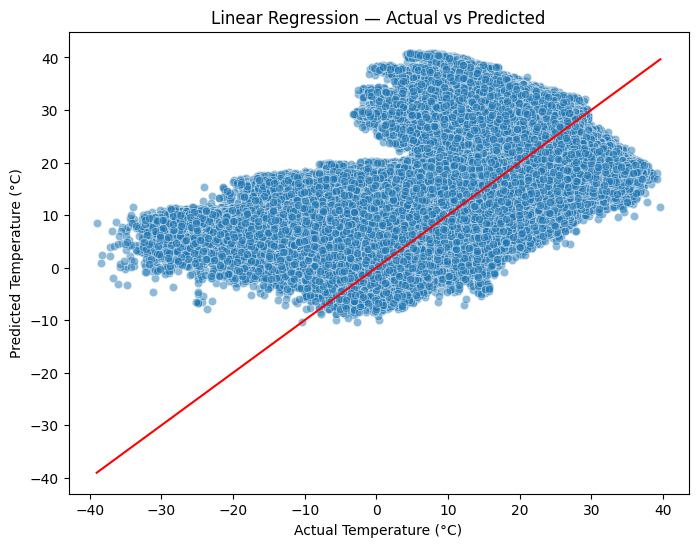

In [29]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=lr_pred, alpha=0.5)
plt.xlabel("Actual Temperature (°C)")
plt.ylabel("Predicted Temperature (°C)")
plt.title("Linear Regression — Actual vs Predicted")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red')
plt.show()

# **5.2 Residual Errors**

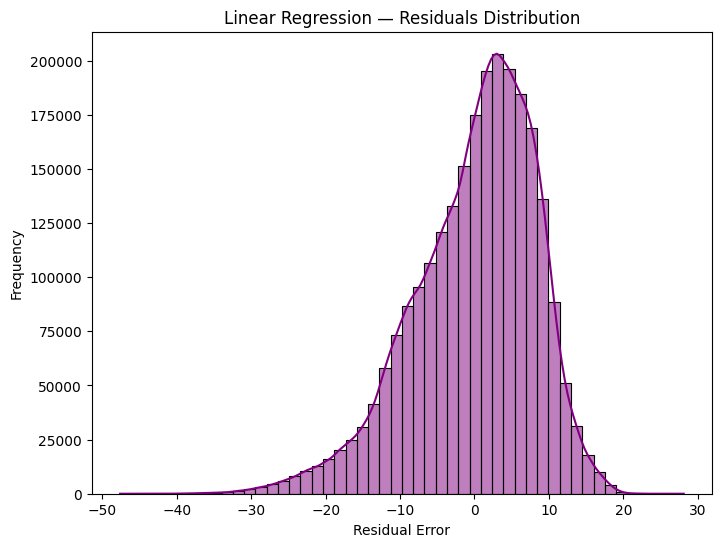

In [30]:
residuals = y_test - lr_pred
plt.figure(figsize=(8,6))
sns.histplot(residuals, bins=50, kde=True, color='purple')
plt.title("Linear Regression — Residuals Distribution")
plt.xlabel("Residual Error")
plt.ylabel("Frequency")
plt.show()

# **6. Save Model**

In [31]:
joblib.dump(lr_model, "linear_regression_planetheat.pkl")
print("Model saved as linear_regression_planetheat.pkl")

Model saved as linear_regression_planetheat.pkl


# **Model 2 — Random Forest Regressor**

In [32]:
from sklearn.ensemble import RandomForestRegressor

# **Model Initialization**

In [33]:
rf_model = RandomForestRegressor(
    n_estimators=12,
    max_depth=15,
    max_features= 'sqrt',
    random_state=42,
    n_jobs=-1
)


In [34]:
print("Training Random Forest Regressor...")
rf_model.fit(X_train, y_train)
print("Random Forest model trained successfully.")


Training Random Forest Regressor...
Random Forest model trained successfully.


# **Prediction**

In [35]:
rf_pred = rf_model.predict(X_test)

# **Model Evaluation**

In [36]:
rf_mae = mean_absolute_error(y_test, rf_pred)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))
rf_r2 = r2_score(y_test, rf_pred)

In [37]:
print("\n Random Forest Performance:")
print(f"Mean Absolute Error (MAE): {rf_mae:.3f}")
print(f"Root Mean Squared Error (RMSE): {rf_rmse:.3f}")
print(f"R² Score: {rf_r2:.3f}")



 Random Forest Performance:
Mean Absolute Error (MAE): 1.202
Root Mean Squared Error (RMSE): 1.621
R² Score: 0.975


# **Visualization: Actual vs Predicted**

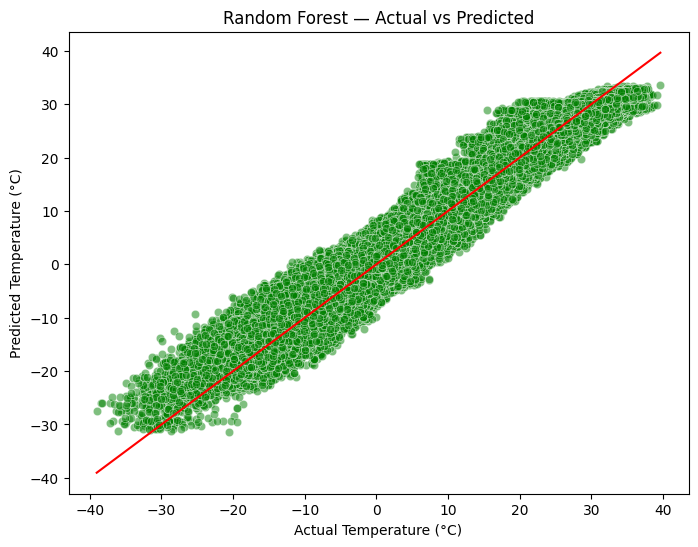

In [38]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=rf_pred, alpha=0.5, color='green')
plt.xlabel("Actual Temperature (°C)")
plt.ylabel("Predicted Temperature (°C)")
plt.title("Random Forest — Actual vs Predicted")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red')
plt.show()

# **Visualization: Residual Errors**

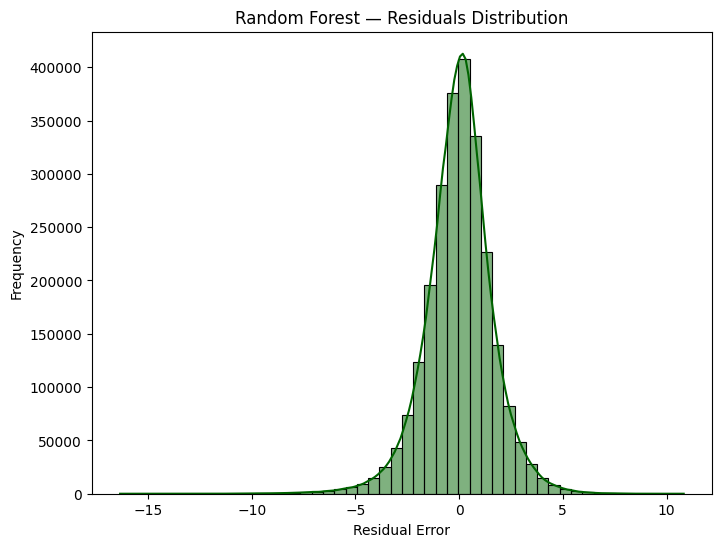

In [39]:
residuals = y_test - rf_pred
plt.figure(figsize=(8,6))
sns.histplot(residuals, bins=50, kde=True, color='darkgreen')
plt.title("Random Forest — Residuals Distribution")
plt.xlabel("Residual Error")
plt.ylabel("Frequency")
plt.show()


# **Save Model**

In [40]:
joblib.dump(rf_model, "random_forest_planetheat.pkl")
print("Model saved as random_forest_planetheat.pkl")

Model saved as random_forest_planetheat.pkl


# **Model 3 — Support Vector Regressor (SVR)**

In [41]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler

# **Subset the Data**

we are goint to subset the dataset, becuase it taking too much time to train the model, we have about 8.5M instances, so we tried a lot to train SVR on whole dataset, but eventually it's helping us, so we just train it on 40K instances

In [53]:
df_svr_sample = df.sample(n=4000, random_state=42)

X_svr = df_svr_sample[features]
y_svr = df_svr_sample[target]


# **Train-Test Split**

In [54]:
X_train, X_test, y_train, y_test = train_test_split(
    X_svr, y_svr, test_size=0.3, random_state=42
)

# **Feature Scaling**

In [55]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# **Initializing the Model**

In [56]:
svr_model = SVR(kernel='linear', C=1.0, epsilon=0.1)

# **Model Training**

In [57]:
print("Training Support Vector Regressor...")
svr_model.fit(X_train, y_train)
print("SVR model trained successfully.")

Training Support Vector Regressor...
SVR model trained successfully.


# **Prediction**

In [58]:
svr_pred = svr_model.predict(X_test)

# **Model Evaluation**

In [59]:
svr_mae = mean_absolute_error(y_test, svr_pred)
svr_rmse = np.sqrt(mean_squared_error(y_test, svr_pred))
svr_r2 = r2_score(y_test, svr_pred)

In [60]:
print("\n SVR Performance:")
print(f"Mean Absolute Error (MAE): {svr_mae:.3f}")
print(f"Root Mean Squared Error (RMSE): {svr_rmse:.3f}")
print(f"R² Score: {svr_r2:.3f}")


 SVR Performance:
Mean Absolute Error (MAE): 6.434
Root Mean Squared Error (RMSE): 8.212
R² Score: 0.373


# **Visualization: Actual vs Predicted**

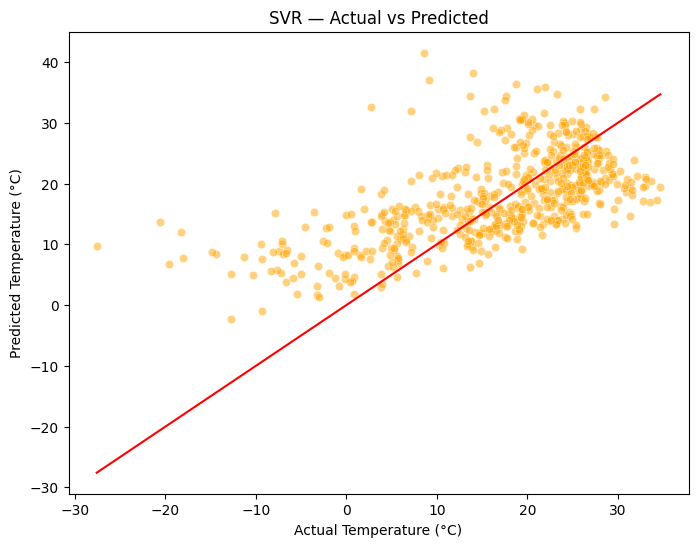

In [50]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=svr_pred, alpha=0.5, color='orange')
plt.xlabel("Actual Temperature (°C)")
plt.ylabel("Predicted Temperature (°C)")
plt.title("SVR — Actual vs Predicted")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red')
plt.show()


# **Visualization: Residual Errors**

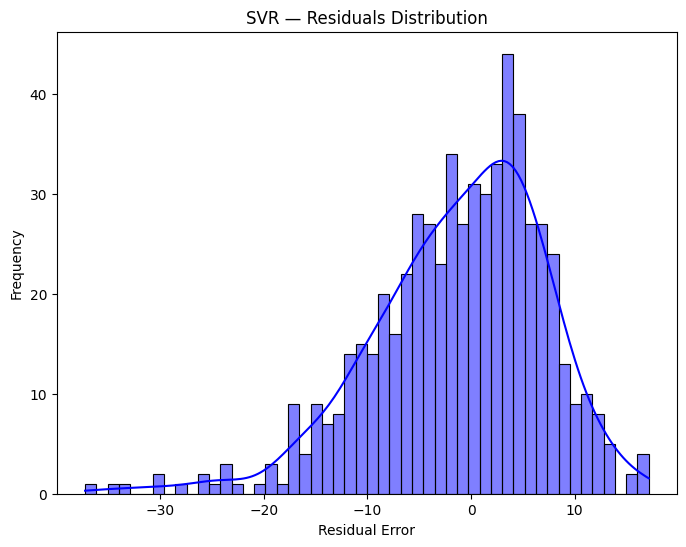

In [51]:
residuals = y_test - svr_pred
plt.figure(figsize=(8,6))
sns.histplot(residuals, bins=50, kde=True, color='blue')
plt.title("SVR — Residuals Distribution")
plt.xlabel("Residual Error")
plt.ylabel("Frequency")
plt.show()

# **Save Model**

In [52]:
joblib.dump(svr_model, "svr_planetheat.pkl")
print("Model saved as svr_planetheat.pkl")

Model saved as svr_planetheat.pkl
